In [11]:
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [12]:
# Load the CT volume and infection mask
ct_volume = nib.load(r'C:\Users\BAPS\Documents\Dicom Analaysis\Dicom_Analyzer\Slice_Classifier\Dataset\Covid_Dataset\ct_scans\coronacases_org_001.nii').get_fdata()          # Shape: (512, 512, num_slices)
infection_mask = nib.load(r'C:\Users\BAPS\Documents\Dicom Analaysis\Dicom_Analyzer\Slice_Classifier\Dataset\Covid_Dataset\infection_mask\coronacases_001.nii').get_fdata()  # Same shape as ct_volume


# Verify shapes match
assert ct_volume.shape == infection_mask.shape, "CT and mask shapes do not match!"

In [13]:
# Identify slices with infections (1) vs. normal (0)
abnormal_slices = []
for slice_idx in range(infection_mask.shape[2]):
    if np.any(infection_mask[:, :, slice_idx]):
        abnormal_slices.append(1)
    else:
        abnormal_slices.append(0)

# Create DataFrame
df = pd.DataFrame({
    'slice_number': list(range(infection_mask.shape[2])),  # 0-based index
    'label': abnormal_slices
})

print(f"Total slices: {len(df)}")
print(f"Abnormal slices: {df['label'].sum()} ({(df['label'].sum()/len(df))*100:.2f}%)")

Total slices: 301
Abnormal slices: 161 (53.49%)


In [14]:
# Split into train/test (stratify to preserve class balance)
X = df['slice_number'].values  # Slice indices (0-based)
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,  
    random_state=42
)

print(f"Train slices: {len(X_train)}")
print(f"Test slices: {len(X_test)}")

Train slices: 240
Test slices: 61



For CT slice index 222:
Total patches created: 1024
Patch 1 shape: (16, 16)
Patch 2 shape: (16, 16)
Patch 3 shape: (16, 16)
Patch 4 shape: (16, 16)
Patch 5 shape: (16, 16)


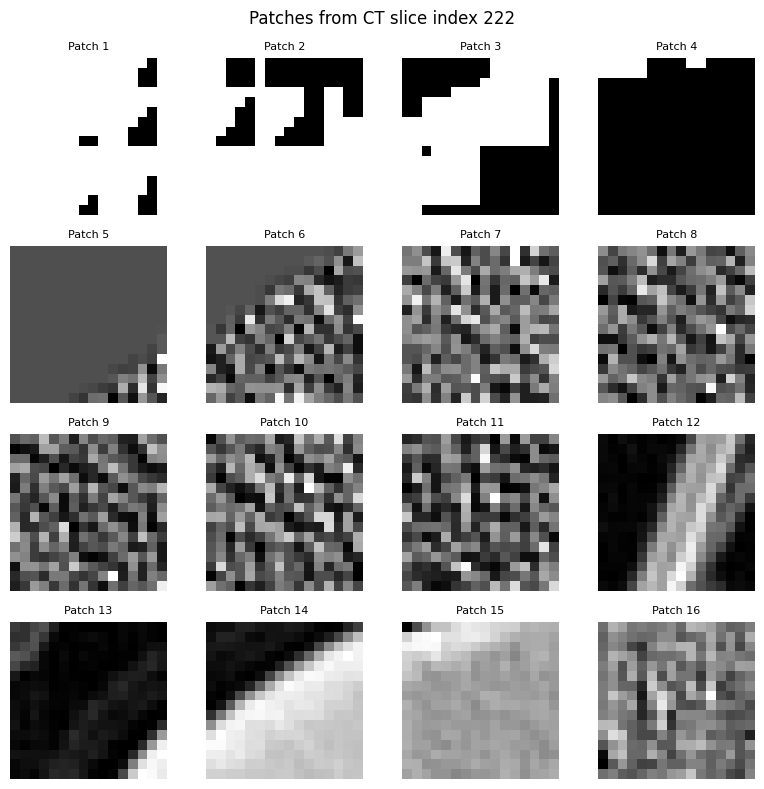

In [15]:
def create_patches(image, patch_size):
    """
    Splits a 2D image into non-overlapping patches.
    
    Args:
        image (np.ndarray): 2D image array.
        patch_size (int): Height and width of each patch.
        
    Returns:
        List of patches (each patch is a np.ndarray of shape (patch_size, patch_size)).
    """
    patches = []
    h, w = image.shape
    # Loop through the image with step equal to patch_size
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            # Extract the patch; ensure it's full size (skip incomplete patches if any)
            patch = image[i:i+patch_size, j:j+patch_size]
            if patch.shape == (patch_size, patch_size):
                patches.append(patch)
    return patches

# Choose a patch size (e.g., 16, 32, etc.). For a 512x512 slice, patch_size=16 will yield (512/16)^2 = 1024 patches.
patch_size = 16

# Let's pick a sample slice from the training set
sample_slice_index = X_train[0]
ct_slice = ct_volume[:, :, sample_slice_index]  # Get the 2D CT slice

# Create patches for this slice
patches = create_patches(ct_slice, patch_size)

# Print total number of patches and the shape of a few patches
print(f"\nFor CT slice index {sample_slice_index}:")
print(f"Total patches created: {len(patches)}")
for idx, patch in enumerate(patches[:5]):  # Print first 5 patch sizes
    print(f"Patch {idx+1} shape: {patch.shape}")


num_to_display = min(16, len(patches))
grid_cols = int(np.ceil(np.sqrt(num_to_display)))
grid_rows = int(np.ceil(num_to_display / grid_cols))

plt.figure(figsize=(grid_cols*2, grid_rows*2))
for i in range(num_to_display):
    plt.subplot(grid_rows, grid_cols, i+1)
    plt.imshow(patches[i], cmap='gray')
    plt.title(f"Patch {i+1}", fontsize=8)
    plt.axis('off')
plt.suptitle(f"Patches from CT slice index {sample_slice_index}", fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
from tqdm import tqdm
class CTDataset(Dataset):
    def __init__(self, ct_volume, slice_indices, labels, transform=None):
        """
        Args:
            ct_volume (np.ndarray): 3D CT volume of shape (H, W, num_slices).
            slice_indices (array-like): Indices of slices to include.
            labels (array-like): Labels corresponding to each slice.
            transform: Optional transformation to apply.
        """
        self.ct_volume = ct_volume
        self.slice_indices = slice_indices
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.slice_indices)

    def __getitem__(self, idx):
        slice_idx = self.slice_indices[idx]
        # Extract the 2D slice and convert to a tensor; add channel dimension (grayscale)
        image = torch.tensor(self.ct_volume[:, :, slice_idx], dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        return image, label

# Create DataLoaders for training and testing
batch_size = 8
train_dataset = CTDataset(ct_volume, X_train, y_train)
test_dataset = CTDataset(ct_volume, X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# -----------------------------
# 5. Define the Vision Transformer (ViT) model
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size, embed_dim, image_size):
        """
        Splits an image into patches and projects them into an embedding space.
        """
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x shape: (batch_size, in_channels, image_size, image_size)
        x = self.proj(x)  # -> (batch_size, embed_dim, num_patches_h, num_patches_w)
        x = x.flatten(2)  # -> (batch_size, embed_dim, num_patches)
        x = x.transpose(1, 2)  # -> (batch_size, num_patches, embed_dim)
        return x

class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, 
                 in_channels=1,         # For grayscale CT slices
                 image_size=512, 
                 patch_size=16, 
                 embed_dim=768, 
                 num_heads=12, 
                 depth=6, 
                 num_classes=2,         # Abnormal vs. normal
                 mlp_ratio=4.0, 
                 dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(in_channels, patch_size, embed_dim, image_size)
        num_patches = (image_size // patch_size) ** 2
        
        # Class token and positional embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        # Transformer encoder blocks
        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_ratio, dropout) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
    
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.patch_embed(x)  # (batch_size, num_patches, embed_dim)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # (batch_size, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (batch_size, num_patches + 1, embed_dim)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        cls_token_final = x[:, 0]  # Use the class token for classification
        out = self.head(cls_token_final)
        return out

# -----------------------------
# 6. Set up training: device, model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer(
    in_channels=1,
    image_size=512,
    patch_size=16,
    embed_dim=768,
    num_heads=1,
    depth=6,
    num_classes=2,
    mlp_ratio=4.0,
    dropout=0.1
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# -----------------------------
# 7. Training and Evaluation Loops
num_epochs = 50

def evaluate(model, data_loader, device):
    model.eval()
    correct, total = 0, 0
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    avg_train_loss = running_loss / len(train_dataset)
    val_loss, val_accuracy = evaluate(model, test_loader, device)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy*100:.2f}%")

# -----------------------------
# 8. Visualize some predictions on the test set
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(12, 3))
for i in range(min(8, images.size(0))):
    plt.subplot(1, 8, i+1)
    plt.imshow(images[i].cpu().squeeze(0), cmap='gray')
    plt.title(f"GT: {labels[i].item()}\nPred: {preds[i].item()}", fontsize=8)
    plt.axis('off')
plt.suptitle("Test Set Predictions")
plt.tight_layout()
plt.show()

Epoch 1/50:   7%|▋         | 2/30 [00:56<13:31, 28.98s/it]

In [1]:
import os
import pydicom
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Set the path to your root folder containing DICOM slices (and subfolders)
root_folder = r"C:\Users\BAPS\Documents\Dicom Analaysis\Dicom_Dataset\Single Sliced Dataset\CMB-MML\MSB-00140"

# Make sure your model is in evaluation mode
model.eval()

# Set your device (e.g., cuda or cpu)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# IMPORTANT: Set these to your computed dataset mean and std
dataset_mean = 0.5  # <-- replace with your actual mean
dataset_std = 0.25  # <-- replace with your actual std

# List to store slices that are predicted to be anomalous
anomalies = []

# Gather all file paths from the folder and its subdirectories
all_file_paths = []
for root, dirs, files in os.walk(root_folder):
    for file in files:
        all_file_paths.append(os.path.join(root, file))

# Create a progress bar for all files
progress_bar = tqdm(all_file_paths, desc="Processing DICOM slices", ncols=100)

for file_path in progress_bar:
    # Try reading the file as a DICOM; if it fails, skip it.
    try:
        dicom_data = pydicom.dcmread(file_path)
    except Exception:
        continue

    # Get the pixel array from the DICOM and convert to float32
    ct_slice = dicom_data.pixel_array.astype(np.float32)
    
    # Normalize the slice to [0, 1]
    ct_slice_norm = (ct_slice - np.min(ct_slice)) / (np.max(ct_slice) - np.min(ct_slice) + 1e-8)
    
    # Convert the normalized slice to a PyTorch tensor and add a channel dimension: [1, H, W]
    ct_tensor = torch.tensor(ct_slice_norm).unsqueeze(0)  # shape: [1, H, W]
    
    # Resize the tensor to 224x224 using F.interpolate.
    # First, add a batch dimension so the shape becomes [1, 1, H, W]
    ct_tensor = ct_tensor.unsqueeze(0)
    ct_tensor = F.interpolate(ct_tensor, size=(224, 224), mode='bilinear', align_corners=False)
    # Remove the batch dimension so it's back to [1, 299, 299]
    ct_tensor = ct_tensor.squeeze(0)
    
    # Apply standardization using the dataset mean and std (same as in your training)
    ct_tensor = (ct_tensor - dataset_mean) / dataset_std
    
    # Add a batch dimension: [1, 1, 299, 299] and move to the correct device
    ct_tensor = ct_tensor.unsqueeze(0).to(device)
    
    # Run model inference
    with torch.no_grad():
        output = model(ct_tensor).squeeze()  # output is the logit
    probability = torch.sigmoid(output).item()  # convert logit to probability
    prediction = 1 if probability > 0.5 else 0  # threshold at 0.5
    
    # Update the progress bar with the current file's info
    progress_bar.set_postfix_str(f"File: {os.path.basename(file_path)} | Pred: {prediction} | Prob: {probability:.4f}")
    
    # Save details if an anomaly is detected
    if prediction == 1:
        anomalies.append((file_path, probability))

# Print a summary of slices with potential anomalies
print("\nAnomalies detected in the following slices:")
if anomalies:
    for path, prob in anomalies:
        print(f"{path} - Probability: {prob:.4f}")
else:
    print("No anomalies detected in the provided folder and its subfolders.")


NameError: name 'model' is not defined